In [50]:
import os 
import pandas as pd
import subprocess as sp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick
import pyarrow.parquet as pq

In [51]:
# standardized paths
base_path = sp.getoutput('git rev-parse --show-toplevel')
eda_figures_path = os.path.join(base_path, 'eda' , 'eda_figures')
data_path = os.path.join(base_path, 'data')
csv_list = os.listdir(data_path)


In [52]:
df_list = []

for filename in csv_list:

    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_path,filename), index_col=None, header=0)

    elif filename.endswith('.parquet'):
        df = pq.read_table(os.path.join(data_path,filename), index_col=None, header=0)
        df = df.to_pandas()
        
    df_list.append(df)

df_base = pd.concat(df_list, axis=0, ignore_index=True)

/var/folders/qv/vr4x2m4s0m53q79m582_pwt00000gn/T/ipykernel_63469/938624743.py:6: DtypeWarning: Columns (58,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_path,filename), index_col=None, header=0)
/var/folders/qv/vr4x2m4s0m53q79m582_pwt00000gn/T/ipykernel_63469/938624743.py:6: DtypeWarning: Columns (17,60,62,64,66,68,70,72,74) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_path,filename), index_col=None, header=0)
/var/folders/qv/vr4x2m4s0m53q79m582_pwt00000gn/T/ipykernel_63469/938624743.py:6: DtypeWarning: Columns (58,60,62,64,66) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_path,filename), index_col=None, header=0)
/var/folders/qv/vr4x2m4s0m53q79m582_pwt00000gn/T/ipykernel_63469/938624743.py:6: DtypeWarning: Columns (17,56,58,60,62) have mixed types. Specify dtype option on import or set

## Number of Cases per Judge

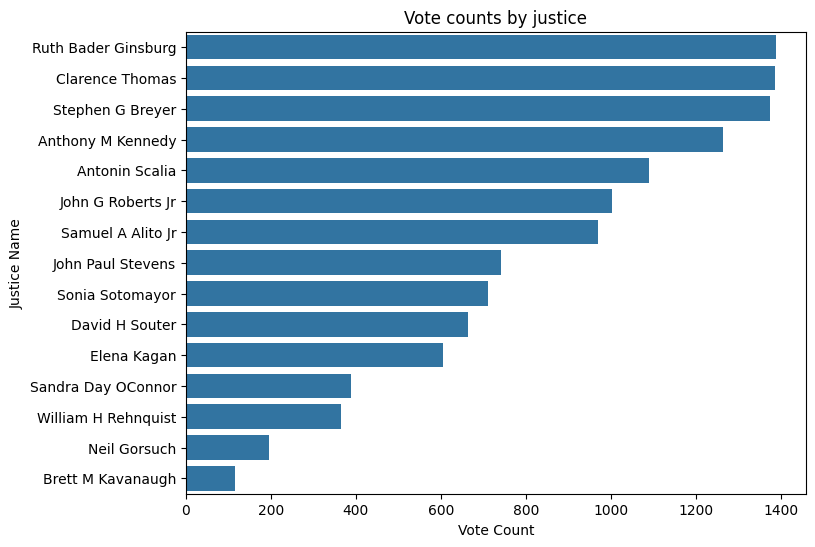

In [73]:
data = [ # dm'd from matt
        ('Ruth Bader Ginsburg', 1390),
        ('Clarence Thomas', 1387),
        ('Stephen G Breyer', 1376),
        ('Anthony M Kennedy', 1264),
        ('Antonin Scalia', 1090),
        ('John G Roberts Jr', 1003),
        ('Samuel A Alito Jr', 969),
        ('John Paul Stevens', 741),
        ('Sonia Sotomayor', 710),
        ('David H Souter', 665),
        ('Elena Kagan', 605),
        ('Sandra Day OConnor', 388),
        ('William H Rehnquist', 365),
        ('Neil Gorsuch', 195),
        ('Brett M Kavanaugh', 115)
        ]

df = pd.DataFrame(data, columns=['Name', 'Votes'])

default_blue = sns.color_palette()[0]

plt.figure(figsize=(8,6))
sns.barplot(x='Votes', y='Name', data=df, color=default_blue)
plt.title('Vote counts by justice')
plt.xlabel('Vote Count')
plt.ylabel('Justice Name')

plt.savefig(os.path.join(eda_figures_path, 'votes_per_justice.png'),
            bbox_inches='tight')

## Vote Rate Per Judge

## Histogram of utterance word count

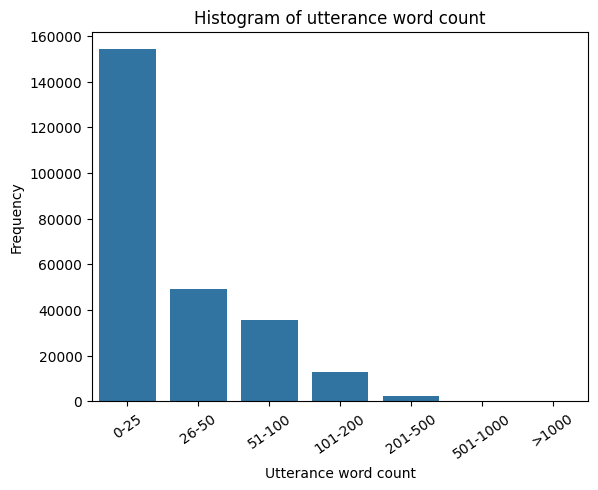

In [54]:
df = df_base.copy()

# Define a function to count words in a string
def count_words(s):
    return len(s.split())

# Apply the function to the text column and store the result in a new column
df['word_count'] = df['text'].apply(count_words)

bins = [0, 26, 51, 101, 201, 501, 1001, df['word_count'].max()]
labs = []
for i, lab in enumerate(bins[0:-1]):
    if i == 0:
        continue
    labs.append(f'{bins[i-1]}-{lab-1}')
labs.append(f'>{bins[-2] - 1}')
word_count_df = pd.DataFrame({'word_count': df['word_count'],
                              'word_count_group': pd.cut(df['word_count'], bins=bins, labels=labs)})

ax = sns.countplot(data=word_count_df, x='word_count_group', color=default_blue)
ax.tick_params(axis='x', labelrotation=35)
plt.xlabel('Utterance word count')
plt.ylabel('Frequency')
plt.title('Histogram of utterance word count');

plt.savefig(os.path.join(eda_figures_path, 'hist_utter_wordcount.png'),
            bbox_inches='tight')


## Number of utterances by case

In [55]:
df = df_base.copy()

In [56]:
df = df_base.copy()
df_utter_by_case = df.groupby(['case_id'], as_index=False).agg({'text': 'count'})

In [57]:
df_utter_by_case.sort_values('text', ascending=False)
#df_utter_by_case['text'].sum()

,case_id,text
887,2011_11-393,898
413,2005_04-473,636
397,2005_04-1360,593
254,2003_02-1674,588
411,2005_04-373,484
...,...,...
818,2010_10-5258,62
975,2013_12-1163,61
1173,2016_15-1503,51
386,2005_04-1144,39


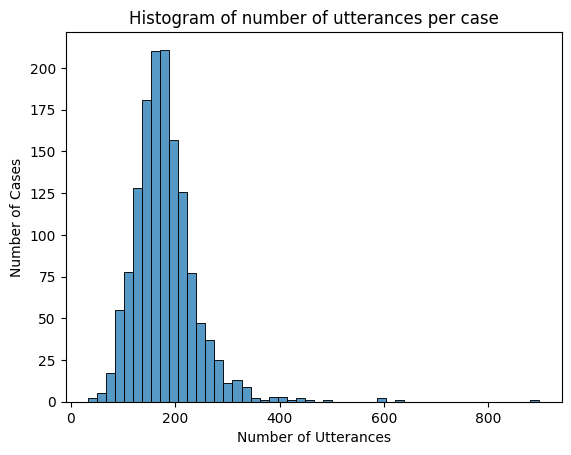

In [70]:

# Now use seaborn to plot a histogram of the aggregated data
sns.histplot(data=df_utter_by_case, x='text', bins=50)
plt.title('Histogram of number of utterances per case')
plt.ylabel('Number of Cases')
plt.xlabel('Number of Utterances')

plt.savefig(os.path.join(eda_figures_path, 'hist_num_utterances_per_case.png'),
            bbox_inches='tight')


## Median length of utterance by case

In [59]:
df = df_base.copy()

In [60]:
# Define a function to count words in a string
def count_words(s):
    return len(s.split())

In [61]:
df['word_count'] = df['text'].apply(count_words)

In [62]:
df_utter_length_by_case = df.groupby(['case_id'], as_index=False).agg({'word_count': 'median'})

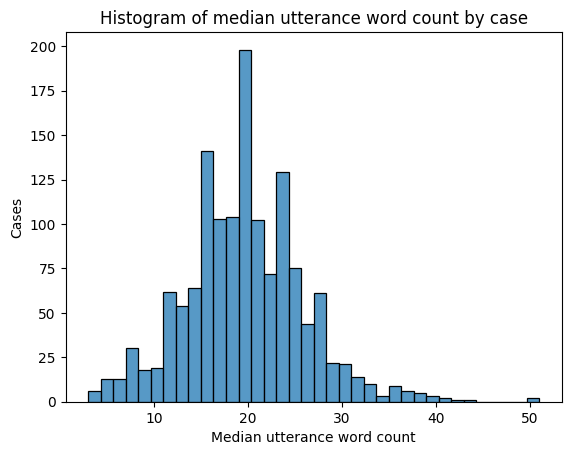

In [68]:
sns.histplot(data=df_utter_length_by_case, x='word_count')
plt.xlabel('Median utterance word count')
plt.ylabel('Cases')
plt.title('Histogram of median utterance word count by case');

plt.savefig(os.path.join(eda_figures_path, 'hist_median_num_utterances_per_case.png'),
            bbox_inches='tight')

## Number of Words Per Case

In [77]:
df

,id,text,speaker,reply_to,conversation_id,case_id,speaker_type,side,timestamp,addressing,...,advocates_19_id,advocates_19_side,advocates_20_id,advocates_20_side,advocates_21_id,advocates_21_side,speaker_replied_to,speaker_type_replied_to,speaker_addressed,speaker_type_addressed
0,22620__0_002,"Well, isn't there something different here? Be...",j__david_h_souter,22620__0_001,22620,2005_04-433,J,NaN,162.447,22620__0_003,...,NaN,NaN,NaN,NaN,NaN,NaN,david_c_frederick,A,david_c_frederick,A
1,22620__0_003,"I don't agree, Justice Souter, and here's why....",david_c_frederick,22620__0_002,22620,2005_04-433,A,1.0,221.594,22620__0_004,...,NaN,NaN,NaN,NaN,NaN,NaN,j__david_h_souter,J,j__david_h_souter,J
2,22620__0_004,"Sure, but they suffered the harm because the f...",j__david_h_souter,22620__0_003,22620,2005_04-433,J,NaN,245.526,22620__0_005,...,NaN,NaN,NaN,NaN,NaN,NaN,david_c_frederick,A,david_c_frederick,A
3,22620__0_006,"Well, why... why is that true? Let's assume th...",j__anthony_m_kennedy,22620__0_005,22620,2005_04-433,J,NaN,326.156,22620__0_007,...,NaN,NaN,NaN,NaN,NaN,NaN,david_c_frederick,A,david_c_frederick,A
4,22620__0_008,"Mr. Frederick, you... you started by saying ho...",j__ruth_bader_ginsburg,22620__0_007,22620,2005_04-433,J,NaN,409.067,22620__0_009,...,NaN,NaN,NaN,NaN,NaN,NaN,david_c_frederick,A,david_c_frederick,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253911,24969__2_005,But accomplice liability --,j__sonia_sotomayor,24969__2_004,24969,2019_19-67,J,NaN,3494.880,24969__2_006,...,NaN,NaN,NaN,NaN,NaN,NaN,eric_j_feigin,A,eric_j_feigin,A
253912,24969__2_006,"-- ""induce"" in Williams.",eric_j_feigin,24969__2_005,24969,2019_19-67,A,1.0,3495.760,24969__2_007,...,NaN,NaN,NaN,NaN,NaN,NaN,j__sonia_sotomayor,J,j__sonia_sotomayor,J
253913,24969__2_007,-- has all sorts of meaning that you're not en...,j__sonia_sotomayor,24969__2_006,24969,2019_19-67,J,NaN,3496.800,24969__2_008,...,NaN,NaN,NaN,NaN,NaN,NaN,eric_j_feigin,A,eric_j_feigin,A
253914,24969__2_008,"No, Your Honor --",eric_j_feigin,24969__2_007,24969,2019_19-67,A,1.0,3506.040,24969__2_009,...,NaN,NaN,NaN,NaN,NaN,NaN,j__sonia_sotomayor,J,j__sonia_sotomayor,J


In [75]:
df = df_base

In [78]:
# Concatenate utterances for each case_id
df_case_words = df.groupby('case_id')['text'].apply(' '.join).reset_index()

# Count the number of words per case
df_case_words['word_count'] = df_case_words['text'].apply(lambda x: len(x.split()))

In [79]:
df_case_words

,case_id,text,word_count
0,2000_00-1011,You say the legal validity of his deportation ...,5307
1,2000_00-151,May I ask one question on that subject Ms. Und...,4713
2,2000_00-152,"Very well, Mr. Kerrigan, you may proceed. Mr. ...",9150
3,2000_00-157,Is the theory of the statute that development ...,5442
4,2000_00-189,Would you mind if I just get a little backgrou...,9160
...,...,...,...
1402,2019_19-631,"Thank you, Mr. Chief Justice, and may it pleas...",7868
1403,2019_19-635,"Thank you, Mr. Chief Justice, and may it pleas...",11621
1404,2019_19-67,"Thank you, Mr. Chief Justice, and may it pleas...",5781
1405,2019_19-7,"Mr. Shanmugam, this case has kind of an academ...",6662


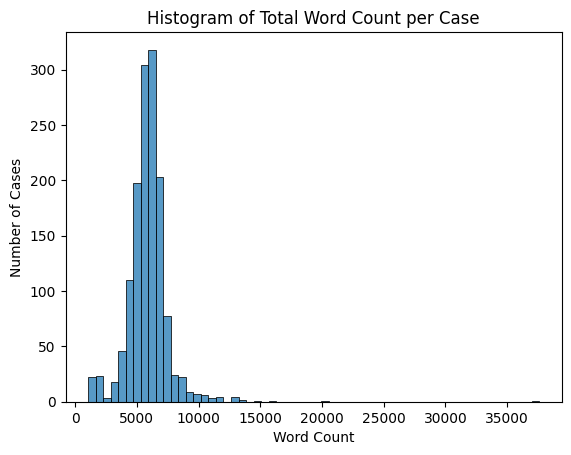

In [87]:
sns.histplot(data=df_case_words, x='word_count', bins=60, color=default_blue)
plt.title('Histogram of Total Word Count per Case')
plt.xlabel('Word Count')
plt.ylabel('Number of Cases');

plt.savefig(os.path.join(eda_figures_path, 'num_words_per_case.png'),
            bbox_inches='tight')

## Win side

In [64]:
df = df_base.copy()

In [65]:
df_avg_case_outcome = (df.groupby(['case_id'], as_index=False)
                         .agg({'win_side': 'mean'}))

In [66]:
avg_case_outcome_all_data = (df.groupby(['case_id'], as_index=False)
                                  .agg({'win_side': 'mean'})
                                  ['win_side'].mean())

In [67]:
avg_case_outcome_all_data

0.6609686609686609